In [1]:
import sys

sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata


from matplotlib.patches import Rectangle

def plot_hypercubes(ax, hypercubes: torch.Tensor, color="C0", alpha=0.4):
    for h in hypercubes:
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(low, side_lengths[0], side_lengths[1], facecolor=color, alpha=alpha)
        ax.add_patch(patch)

def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

## Generating the dataset

In [2]:
# run pip install gymnasium[classic-control]
import numpy as np
import gymnasium as gym
env = gym.make('MountainCarContinuous-v0')
env.action_space.seed(42)
observation, info = env.reset(seed=42)

AList = []
XList = []
YList = []
XAList = []

target_size = 1

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    observationWithAction = observation 
    XAList.append(np.concatenate((observation, action), axis=0))
    AList.append(action)
    XList.append(observation)
    YList.append(reward)

    if terminated or truncated:
        print("Ended with",_,"cycles")
        observation, info = env.reset()
env.close()

A = np.array(AList)
X = np.array(XList)
Y = np.array(YList)
XA = np.array(XAList)

print("Observations & Actions",XA)

#print("Actions",A)
print("Observations",X)
#print("Targets",Y)
#print(type(A),type(X),type(Y))
feature_size = XA[0].size
#print("feature_size", feature_size)


Ended with 998 cycles
Observations & Actions [[-4.4496945e-01  2.3934752e-04  5.4791212e-01]
 [-4.4549772e-01 -5.2828336e-04 -1.2224312e-01]
 [-4.4553062e-01 -3.2902666e-05  7.1719587e-01]
 ...
 [-8.0072439e-01  2.5603069e-02 -9.9538243e-01]
 [-7.7179408e-01  2.8930325e-02  9.8673701e-01]
 [-5.1296693e-01 -7.4260280e-04 -4.3820724e-01]]
Observations [[-4.4496945e-01  2.3934752e-04]
 [-4.4549772e-01 -5.2828336e-04]
 [-4.4553062e-01 -3.2902666e-05]
 ...
 [-8.0072439e-01  2.5603069e-02]
 [-7.7179408e-01  2.8930325e-02]
 [-5.1296693e-01 -7.4260280e-04]]


## Splitting the dataset intro train and test

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XA,Y,test_size = 0.20,random_state = 42) 
print(type(X_train),type(y_train))
print("X_train",X_train)
print("y_train",y_train)
print("X_test",X_test)
print("y_test",y_test)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
X_train [[-0.5363275  -0.00518089  0.3660979 ]
 [-0.50841796  0.01675114 -0.5818847 ]
 [-0.31115323  0.01325905  0.05908411]
 ...
 [-0.16954474  0.00935714  0.48343283]
 [-0.7079449  -0.01224347 -0.5964358 ]
 [-0.5916062  -0.00321862 -0.46826008]]
y_train [-1.34027670e-02 -3.38589783e-02 -3.49093205e-04 -3.84352722e-05
 -2.67128187e-02 -1.64890347e-02 -6.66442288e-03 -1.52933350e-02
 -9.66068173e-04 -4.52243282e-02 -1.14830089e-03 -3.45439827e-05
 -2.43531449e-02 -2.88840602e-02 -9.23778014e-03 -3.54252116e-02
 -9.99483789e-03 -2.19738606e-03 -6.06242614e-02 -1.51850129e-03
 -5.53554851e-04 -7.72540948e-02 -4.67677049e-03 -5.19113110e-02
 -1.96934741e-02 -5.14369914e-02 -5.13813995e-02 -5.39778772e-03
 -8.43944820e-02 -2.51769175e-04 -3.19505518e-02 -7.18369149e-02
 -3.18934569e-02 -9.18332304e-06 -6.71227515e-03 -8.74261452e-02
 -2.61699720e-03 -5.60510223e-02 -5.69246283e-02 -5.20472946e-02
 -1.55816550e-02 -9.45031755e-02 -1.10051383e-

## Learning with Context

In [4]:
from torch_mas.head import Head
from torch_mas.data import DataBuffer

model = Head(
    feature_size, 
    target_size, 
    R=0.25,
    imprecise_th=0.5,
    bad_th=0.0015,
    alpha=0.5,
    memory_length=3,
    n_epochs=5
)

## Training the agents

In [5]:
import time
dataset = DataBuffer(X_train,y_train)
t = time.time()
model.fit(dataset)
tt = time.time() - t
print(f"Total training time: {tt}s")

print("Number of agents created:", model.agents.n_agents)

Total training time: 2.4602444171905518s
Number of agents created: 29


### Agents Visualization

Text(0, 0.5, 'Y')

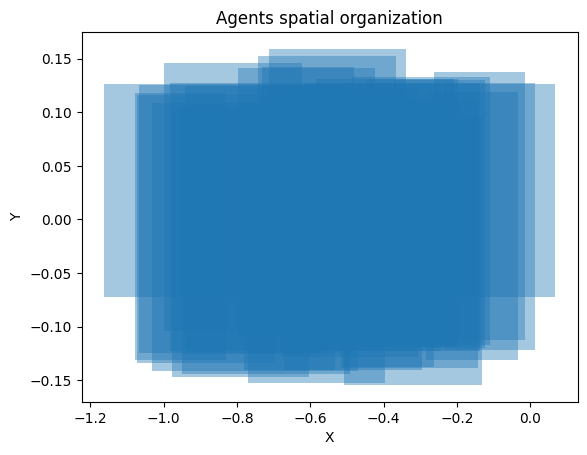

In [6]:
ax = plt.gca()
ax.scatter(dataset.X[:, 0], dataset.X[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, model.agents.hypercubes.detach().numpy())
ax.set_title("Agents spatial organization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

## Computing performance

In [7]:
print(type(X_test))

<class 'numpy.ndarray'>


Total Prediction time: 0.003998279571533203s for 4 samples
Prediction time per sample: 6.663799285888672e-06s
Mean Squared Error: 0.0017945655270311652
y_test tensor([-6.5268e-03, -1.5670e-02, -9.9337e-02, -2.0282e-02, -9.0150e-03,
        -5.3475e-02, -3.4500e-02, -1.9253e-02, -1.1587e-04, -8.4111e-02,
        -9.3478e-02, -1.7041e-02, -1.2293e-02, -6.9505e-02, -6.2765e-02,
        -1.9382e-04, -8.3366e-02, -4.1886e-04, -4.8873e-02, -8.0589e-02,
        -1.7541e-03, -4.4995e-02, -2.1062e-02, -9.8194e-02, -1.5095e-02,
        -3.7054e-02, -1.5953e-02, -1.0063e-02, -8.2747e-02, -4.9374e-02,
        -7.9576e-02, -6.9646e-02, -4.2438e-05, -6.4915e-05, -2.7569e-02,
        -3.6861e-02, -8.4349e-02, -6.9668e-02, -2.3148e-02, -5.9435e-02,
        -7.0668e-03, -7.6383e-03, -2.8608e-02, -1.2740e-02, -8.1206e-03,
        -8.1947e-06, -4.4807e-02, -2.7339e-02, -6.7612e-03, -9.3477e-02,
        -1.0439e-02, -2.6237e-03, -4.2163e-02, -4.9077e-02, -6.1818e-02,
        -2.3963e-02, -9.4258e-03, -6.6

Text(0.5, 1.0, 'Predictions on test')

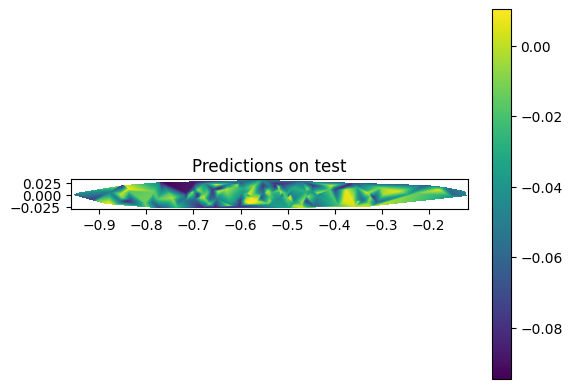

In [8]:
import time
import torch
import math
test_feature_size = X_test.size
t = time.time()
y_pred = model.predict(torch.from_numpy(X_test).float())
y_test = torch.from_numpy(y_test)
tt = time.time() - t
tps = tt / test_feature_size
print(f"Total Prediction time: {tt}s for 4 samples")
print(f"Prediction time per sample: {tps}s")
mse = ((y_pred - y_test) ** 2).mean()
print("Mean Squared Error:", mse.detach().numpy())
print("y_test", y_test)
print("y_pred", y_pred.squeeze())

fig = plt.gcf()
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_pred.detach().squeeze(), interpolation="linear", n_points=1000)
fig.colorbar(pcm)
ax.set_title("Predictions on test")

